# Asset Replacement Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdp02.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Profit-maximizing entrepreneur must decide when to replace an aging asset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisSpline, DPmodel, qnwnorm, demo, NLP

### Model Parameters

The maximum age of the asset is $A=6$,  production function coefficients are $\alpha =[50.0, -2.5, -2.5]$, net replacement cost is $\kappa = 40$, long-run mean unit profit is $\bar{p} = 1$, the unit profit autoregression coefficient is $\gamma = 0.5$, the standard deviation of unit profit shock is $\sigma = 0.15$, and the discount factor is $\delta = 0.9$.


In [2]:
A       = 6
alpha   = np.array([50, -2.5, -2.5])
kappa   = 40
pbar    = 1.0
gamma   = 0.5
sigma   = 0.15
delta   = 0.9

### State space
The state variables are the current unit profit $p$ (continuous) and the age of asset $a\in\{1,2,\dots,A\}$. 

In [3]:
dstates = [f'a={age+1:d}' for age in range(A)]
print('Discrete states are :', dstates)

Discrete states are : ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6']


Here, we approximate the unit profit with a cubic spline basis of $n=200$ nodes, over the interval $p\in[0,2]$.

In [4]:
n  = 200
pmin, pmax = 0.0, 2.0  
basis = BasisSpline(n, pmin, pmax, labels=['unit profit'])

### Action space
There is only one choice variable $j$: whether to keep(0) or replace(1) the asset.

In [5]:
options = ['keep', 'replace']

### Reward Function
The instant profit depends on the asset age and whether it is replaced. An asset of age $a=A$ must be replaced. 
If the asset is replaced, the profit is $50p$ minus the cost of replacement $\kappa$; otherwise the profit depends on the age of the asset, $(\alpha_0 + \alpha_1 a + \alpha_2 a^2)p$.


In [6]:
def profit(p, x, i, j):
    a = i + 1
    if j or a == A:
        return p * 50 - kappa
    else:
        return p * (alpha[0] + alpha[1] * a + alpha[2] * a ** 2 )

### State Transition Function

The unit profit $p$ follows a Markov Process 
\begin{equation}p' = \bar{p} + \gamma(p-\bar{p}) + \epsilon \end{equation}
where $\epsilon \sim N(0,\sigma^2)$.

In [7]:
def transition(p, x, i, j, in_, e):
    return pbar + gamma * (p - pbar) + e

The continuous shock must be discretized. Here we use Gauss-Legendre quadrature to obtain nodes and weights defining a discrete distribution that matches the first 10 moments of the Normal distribution (this is achieved with $m=5$ nodes and weights).

In [8]:
m = 5
e, w = qnwnorm(m,0,sigma ** 2)

On the other hand, the age of the asset is deterministic: if it is replaced now it will be new ($a=0$) next period; otherwise its age will be $a+1$ next period if current age is $a$.

In [9]:
h = np.zeros((2, A),int)
h[0, :-1] = np.arange(1, A)

## Model Structure

In [10]:
model = DPmodel(basis, profit, transition,
                i=dstates,
                j=options,
                discount=delta, e=e, w=w, h=h)

### SOLUTION
The ```solve``` method returns a pandas ```DataFrame```.

In [11]:
S = model.solve()
S.head()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       3.7e+02    0.1556
   1       4.3e+01    0.3241
   2       1.2e+01    0.4887
   3       5.7e-01    0.6662
   4       4.5e-13    0.8417
Elapsed Time =    0.84 Seconds


unit profit  i       value         resid    j*  value[keep]  \
    unit profit                                                                
a=1 0.000000        0.000000  0  234.982583 -5.684342e-14  keep   234.982583   
    0.001001        0.001001  0  235.058576 -6.159590e-07  keep   235.058576   
    0.002001        0.002001  0  235.134563 -6.366804e-07  keep   235.134563   
    0.003002        0.003002  0  235.210544 -2.317537e-07  keep   235.210544   
    0.004002        0.004002  0  235.286520  4.292312e-07  keep   235.286520   

                 value[replace]  
    unit profit                  
a=1 0.000000         206.124123  
    0.001001         206.209036  
    0.002001         206.293949  
    0.003002         206.378862  
    0.004002         206.463774

## Analysis

### Plot Action-Contingent Value Functions

In [12]:
# Compute and Plot Critical Unit Profit Contributions
pcrit = [NLP(lambda s: model.Value_j(s)[i].dot([1,-1])).broyden(0.0)[0] for i in range(A)]
vcrit = [model.Value(s)[i] for i, s in enumerate(pcrit)]

Age 2  Profit  1.50
Age 3  Profit  0.66
Age 4  Profit  0.38
Age 5  Profit  0.25


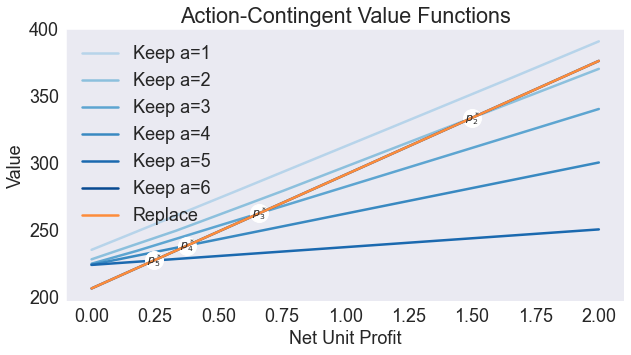

In [13]:
fig1 = demo.figure('Action-Contingent Value Functions', 'Net Unit Profit','Value', figsize=[10,5])

cc = np.linspace(0.3,0.9,model.dims.ni)

for a, i in enumerate(dstates):
    plt.plot(S.loc[i,'value[keep]'] ,color=plt.cm.Blues(cc[a]), label='Keep ' + i)
    if pmin < pcrit[a] < pmax:
        demo.annotate(pcrit[a], vcrit[a], f'$p^*_{a+1}$', 'wo',(0, 0), fs=11, ms=18)
        print(f'Age {a+1:d}  Profit {pcrit[a]:5.2f}')
    
plt.plot(S.loc['a=1','value[replace]'], color=plt.cm.Oranges(0.5),label='Replace')
plt.legend()

### Plot Residual

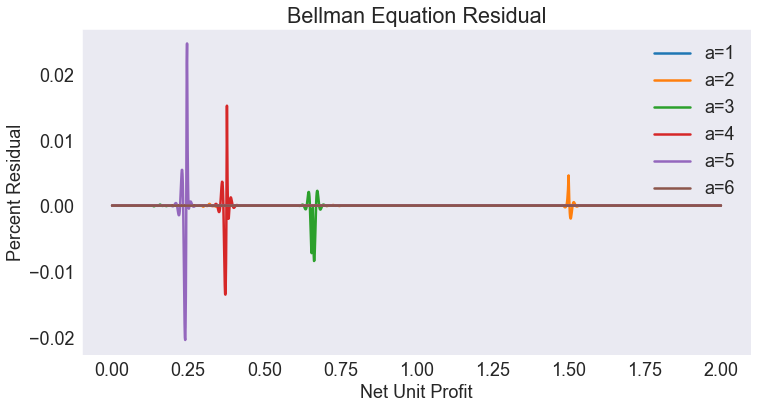

In [14]:
S['resid2'] = 100*S['resid'] / S['value']

fig2 = demo.figure('Bellman Equation Residual','Net Unit Profit','Percent Residual')
demo.qplot('unit profit','resid2','i',S)
plt.legend(model.labels.i)

### SIMULATION

In [15]:
T = 50
nrep = 10000
sinit = np.full(nrep, pbar)
iinit = 0
data = model.simulate(T,sinit,iinit, seed=945)
data['age'] = data.i.cat.codes + 1

### Print Ergodic Moments

In [16]:
frm = '\t{:<10s} = {:5.2f}'

print('\nErgodic Means')
print(frm.format('Price', data['unit profit'].mean()))
print(frm.format('Age', data['age'].mean()))
print('\nErgodic Standard Deviations')
print(frm.format('Price', data['unit profit'].std()))
print(frm.format('Age', data['age'].std()))


Ergodic Means
	Price      =  1.00
	Age        =  2.01

Ergodic Standard Deviations
	Price      =  0.17
	Age        =  0.83


### Plot Simulated and Expected Continuous State Path

In [17]:
data.head()

,time,_rep,i,unit profit,j*,age
0,0,0,a=1,1.0,keep,1
1,0,1,a=1,1.0,keep,1
2,0,2,a=1,1.0,keep,1
3,0,3,a=1,1.0,keep,1
4,0,4,a=1,1.0,keep,1


In [18]:
subdata = data[data['_rep'].isin(range(3))]

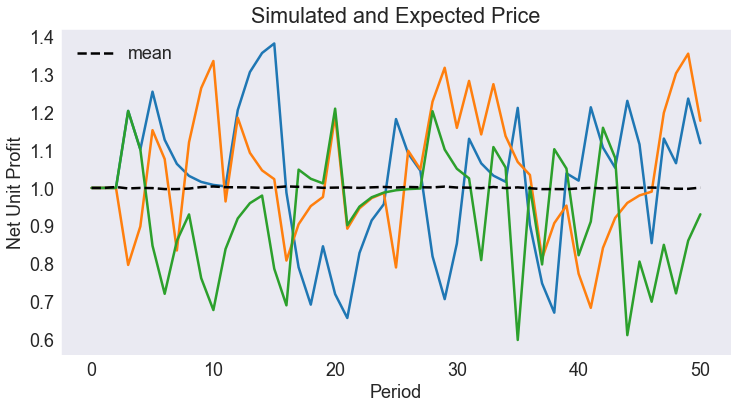

In [19]:
fig3 = demo.figure('Simulated and Expected Price', 'Period','Net Unit Profit')
demo.qplot('time','unit profit','_rep',subdata)
plt.plot(data[['time','unit profit']].groupby('time').mean(),'k--',label='mean')
plt.legend()

### Plot Expected Discrete State Path

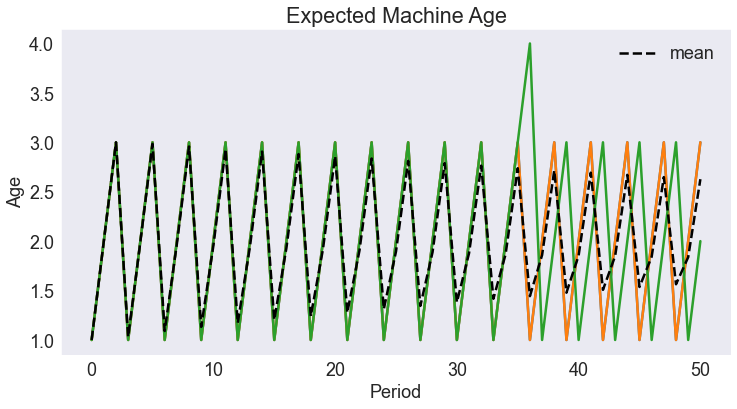

In [20]:
fig4 = demo.figure('Expected Machine Age', 'Period','Age')
demo.qplot('time','age','_rep',subdata)
plt.plot(data[['time','age']].groupby('time').mean(),'k--',label='mean')
plt.legend()